In [10]:
# april 2019
# process audio using windowing (hanning?)

import sys
import numpy as np
import librosa
import librosa.display
import scipy
import matplotlib.pyplot as plt
import audioprocessor

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Reshape, UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, Convolution2D, Deconvolution2D

%matplotlib inline
print(sys.version)


3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]


In [2]:
no_fx, sr = librosa.load('data/3songs/3songs_no_fx.wav', mono=False, sr=None)
reverb, sr = librosa.load('data/3songs/3songs_reverb_util.wav', mono=False, sr=None)

In [1]:
# audioproc = audioprocessor.AudioProcessor('data/3songs/3songs_no_fx.wav', 
#                                           'data/3songs/3songs_reverb_util.wav')
# audioproc.load_data()
# audioproc.fft()
# audioproc.create_training_pairs()

In [3]:
print(sr)
print("original size: ", no_fx.shape)

48000
original size:  (2, 19200000)


In [13]:
# reshape, we're only working in mono now
no_fx = no_fx.reshape(no_fx.shape[1]*2)
reverb = reverb.reshape(reverb.shape[1]*2)

In [14]:
window_size = int(0.2*44100) # 0.2 seconds
history_samples = 20 # 10 blocks of history
history_window_size = history_samples*window_size
batch_size = 128
no_fx_fft = np.abs(librosa.core.stft(no_fx,n_fft=window_size))
reverb_fft = np.abs(librosa.core.stft(reverb,n_fft=window_size))

In [15]:
print("original data shape", no_fx.shape)
print("fft data shape", no_fx_fft.shape)
print(reverb_fft.shape)
# print(no_fx_fft.shape[0]*window_size)
print(no_fx_fft.dtype)

original data shape (38400000,)
fft data shape (4411, 17415)
(4411, 17415)
float32


In [16]:
# istft resampling and writing wav
# no_fx_fft_resamp = librosa.core.istft(no_fx_fft)
# librosa.output.write_wav('data/3songs/resamptest.wav', no_fx_fft_resamp, sr)

In [17]:
# librosa.display.waveplot(no_fx[0:2000], sr=sr)

# librosa.display.specshow(librosa.amplitude_to_db(no_fx_fft,ref=np.max),y_axis='log', x_axis='time')
# plt.title('Power spectrogram')
# plt.colorbar(format='%+2.0f dB')
# plt.tight_layout()

In [18]:
# make the input samples, creating 'images' of history_samples x no_fx_fft.shape[0] (feature length)
# coupled with output vectors of no_fx.shape[0] output vecs

input_list = []
sample_max = 17415
# total amount of samples 17415
for i in range(1,sample_max):
    # add zero padding, leading
    if i < history_samples:
        arr = np.zeros((history_samples,no_fx_fft.shape[0]),dtype="float32")
        arr[-i:,:] = no_fx_fft[:,:i].T
    else:
        arr = no_fx_fft[:,i-history_samples:i].T
#     print(arr.shape)
    input_list.append(arr)
print(len(input_list))
input_arr = np.expand_dims(np.array(input_list),axis=1)
print(input_arr.shape)

17414
(17414, 1, 20, 4411)


In [10]:
# sequential test

# model = Sequential()
# model.add(Conv2D(10, kernel_size=(5, 5), strides=(1, 1),
#                  activation='relu',
#                  input_shape=(history_samples,no_fx_fft.shape[0],1)))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Conv2D(64, (5, 5), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(1000, activation='relu'))
# model.add(Dense(no_fx_fft.shape[0], activation='linear'))

v1:
conv(10,5)
pool(4)
flatten
dense(200)
dense(out)

v2: (mse, rmsprop)
conv(10,5)
pool(3)
conv(10,5)
flatten
dense(300)
dense(out)
Epoch 600
16999/16999 [==============================] - 21s 1ms/step - loss: 4.6010 - acc: 0.7359


v3: MAE is more robust to outliers than MSE (mae, adam)
mean_absolute_error, mean_absolute_percentage_error also possible
--- mae didn't work well as optimization strategy (mae 1.02, acc 0.113)
also different conv
conv(10,(2,5))
pool(3)
conv(10,(2,5))
pool(3)
flatten
dense(300)
dense(out)


v4: LSTM? no
rmsprop, mse
conv(10,(2,5))
pool(3)
conv(10,(2,5))
pool(3)
flatten
dense(300)
dense(out)

In [11]:
history_samples*no_fx_fft.shape[0]

88220

In [66]:
# let's build a model
ker_input = Input(shape=(1,history_samples,no_fx_fft.shape[0]))
Reshape
conv1 = Convolution2D(30,kernel_size=(5,25),strides=(1,10),input_shape=(1,history_samples,no_fx_fft.shape[0]),
               data_format='channels_first',activation='relu')(ker_input)
pool1 = MaxPooling2D(pool_size=2)(conv1)
conv2 = Convolution2D(20,kernel_size=(5,25),strides=(1,5),input_shape=(1,history_samples,no_fx_fft.shape[0]),
               data_format='channels_first',activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=2)(conv2)
midlayer1 = Dense(250, activation='relu')(pool2)
fl = Flatten()(midlayer1)
midlayer2 = Dense(600, activation='relu')(fl)
# upsampling = UpSampling2D(size=(2,2))(midlayer2)
# deconv2 = Deconvolution2D(20,kernel_size=(5,5))(upsampling)
# flattened = Flatten()(deconv2)

# hiddentest = Dense(500,activation='relu')(pool2)
# flattened = Flatten()(hiddentest)#(conv2)
# hidden1 = Dense(1000,activation='relu')(flattened)
# hidden2 = Dense(2000,activation='relu')(hidden1)

# deconv!

# hidden2 = Dense(200)(hidden1)
ker_out = Dense(reverb_fft.shape[0], activation='linear', name='main_output')(midlayer2)

model1 = Model(inputs=ker_input, outputs=ker_out)
model1.compile(optimizer='rmsprop', loss='msle',metrics=['mse', 'msle', 'accuracy', 'mae', 'mape'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 1, 20, 4411)       0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 30, 16, 439)       3780      
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 15, 8, 439)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 20, 4, 83)         37520     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 10, 2, 83)         0         
_________________________________________________________________
dense_73 (Dense)             (None, 10, 2, 250)        21000     
_________________________________________________________________
flatten_37 (Flatten)         (None, 5000)              0         
__________

In [67]:
# batch reshaping
# input_batches = np.array((batch_size,1,no_fx_fft.shape[0],no_fx_fft.shape[1]))
# input_batches
# for i in range(no_fx_fft.shape[1]):
#     pred_index = i+history_samples
    

model1.fit(x=input_arr,y=reverb_fft[:,:sample_max-1].T,batch_size=512,epochs=600,verbose=1)
# np.shape(no_fx_fft.reshape()

Epoch 1/600
17414/17414 [==============================] - 16s 945us/step - loss: 0.6259 - mean_squared_logarithmic_error: 0.6259 - mean_squared_error: 411.7020 - mean_absolute_error: 5.6295 - mean_absolute_percentage_error: 1183851.9162 - acc: 0.0193
Epoch 2/600
17414/17414 [==============================] - 15s 854us/step - loss: 0.3201 - mean_squared_logarithmic_error: 0.3201 - mean_squared_error: 38.1575 - mean_absolute_error: 2.5886 - mean_absolute_percentage_error: 2775943.2223 - acc: 0.0492
Epoch 3/600
17414/17414 [==============================] - 15s 856us/step - loss: 0.2463 - mean_squared_logarithmic_error: 0.2463 - mean_squared_error: 33.2345 - mean_absolute_error: 2.2285 - mean_absolute_percentage_error: 2595615.8404 - acc: 0.0667
Epoch 4/600
17414/17414 [==============================] - 15s 858us/step - loss: 0.2023 - mean_squared_logarithmic_error: 0.2023 - mean_squared_error: 30.2709 - mean_absolute_error: 2.0195 - mean_absolute_percentage_error: 2378783.4257 - acc: 0.

17414/17414 [==============================] - 15s 850us/step - loss: 0.0756 - mean_squared_logarithmic_error: 0.0756 - mean_squared_error: 16.7389 - mean_absolute_error: 1.2782 - mean_absolute_percentage_error: 15987305.4714 - acc: 0.1685
Epoch 66/600
17414/17414 [==============================] - 15s 849us/step - loss: 0.0753 - mean_squared_logarithmic_error: 0.0753 - mean_squared_error: 16.6676 - mean_absolute_error: 1.2780 - mean_absolute_percentage_error: 16522321.1750 - acc: 0.1702
Epoch 67/600
17414/17414 [==============================] - 15s 851us/step - loss: 0.0755 - mean_squared_logarithmic_error: 0.0755 - mean_squared_error: 16.5987 - mean_absolute_error: 1.2767 - mean_absolute_percentage_error: 15947287.0364 - acc: 0.1727
Epoch 68/600
17414/17414 [==============================] - 15s 847us/step - loss: 0.0753 - mean_squared_logarithmic_error: 0.0753 - mean_squared_error: 16.5981 - mean_absolute_error: 1.2770 - mean_absolute_percentage_error: 15934216.7624 - acc: 0.1705
E

17414/17414 [==============================] - 15s 844us/step - loss: 0.0703 - mean_squared_logarithmic_error: 0.0703 - mean_squared_error: 14.9234 - mean_absolute_error: 1.1882 - mean_absolute_percentage_error: 12242238.3462 - acc: 0.2105
Epoch 130/600
17414/17414 [==============================] - 15s 845us/step - loss: 0.0703 - mean_squared_logarithmic_error: 0.0703 - mean_squared_error: 14.9233 - mean_absolute_error: 1.1868 - mean_absolute_percentage_error: 12496903.7009 - acc: 0.2103
Epoch 131/600
17414/17414 [==============================] - 15s 847us/step - loss: 0.0701 - mean_squared_logarithmic_error: 0.0701 - mean_squared_error: 14.8744 - mean_absolute_error: 1.1825 - mean_absolute_percentage_error: 11996269.1168 - acc: 0.2109
Epoch 132/600
17414/17414 [==============================] - 15s 853us/step - loss: 0.0704 - mean_squared_logarithmic_error: 0.0704 - mean_squared_error: 14.9259 - mean_absolute_error: 1.1827 - mean_absolute_percentage_error: 11964673.9549 - acc: 0.211

17414/17414 [==============================] - 15s 847us/step - loss: 0.0680 - mean_squared_logarithmic_error: 0.0680 - mean_squared_error: 14.0953 - mean_absolute_error: 1.1235 - mean_absolute_percentage_error: 10005687.1170 - acc: 0.2265
Epoch 194/600
17414/17414 [==============================] - 15s 849us/step - loss: 0.0677 - mean_squared_logarithmic_error: 0.0677 - mean_squared_error: 14.0169 - mean_absolute_error: 1.1212 - mean_absolute_percentage_error: 9822086.3877 - acc: 0.2282
Epoch 195/600
17414/17414 [==============================] - 15s 847us/step - loss: 0.0677 - mean_squared_logarithmic_error: 0.0677 - mean_squared_error: 14.0052 - mean_absolute_error: 1.1212 - mean_absolute_percentage_error: 9933945.4812 - acc: 0.2268
Epoch 196/600
17414/17414 [==============================] - 15s 843us/step - loss: 0.0678 - mean_squared_logarithmic_error: 0.0678 - mean_squared_error: 14.0498 - mean_absolute_error: 1.1217 - mean_absolute_percentage_error: 10071868.3216 - acc: 0.2266


17414/17414 [==============================] - 15s 844us/step - loss: 0.0663 - mean_squared_logarithmic_error: 0.0663 - mean_squared_error: 13.5119 - mean_absolute_error: 1.0880 - mean_absolute_percentage_error: 8893283.9327 - acc: 0.2364
Epoch 258/600
17414/17414 [==============================] - 15s 841us/step - loss: 0.0661 - mean_squared_logarithmic_error: 0.0661 - mean_squared_error: 13.4771 - mean_absolute_error: 1.0876 - mean_absolute_percentage_error: 8940802.6283 - acc: 0.2335
Epoch 259/600
17414/17414 [==============================] - 15s 847us/step - loss: 0.0661 - mean_squared_logarithmic_error: 0.0661 - mean_squared_error: 13.4904 - mean_absolute_error: 1.0870 - mean_absolute_percentage_error: 8903947.8397 - acc: 0.2353
Epoch 260/600
17414/17414 [==============================] - 15s 843us/step - loss: 0.0661 - mean_squared_logarithmic_error: 0.0661 - mean_squared_error: 13.4795 - mean_absolute_error: 1.0865 - mean_absolute_percentage_error: 8783843.7053 - acc: 0.2352
Ep

17414/17414 [==============================] - 15s 847us/step - loss: 0.0651 - mean_squared_logarithmic_error: 0.0651 - mean_squared_error: 13.1203 - mean_absolute_error: 1.0680 - mean_absolute_percentage_error: 8913560.5251 - acc: 0.2414
Epoch 322/600
17414/17414 [==============================] - 15s 848us/step - loss: 0.0651 - mean_squared_logarithmic_error: 0.0651 - mean_squared_error: 13.0924 - mean_absolute_error: 1.0675 - mean_absolute_percentage_error: 8851705.9600 - acc: 0.2422
Epoch 323/600
17414/17414 [==============================] - 15s 845us/step - loss: 0.0650 - mean_squared_logarithmic_error: 0.0650 - mean_squared_error: 13.1182 - mean_absolute_error: 1.0675 - mean_absolute_percentage_error: 8926251.3056 - acc: 0.2392
Epoch 324/600
17414/17414 [==============================] - 15s 849us/step - loss: 0.0651 - mean_squared_logarithmic_error: 0.0651 - mean_squared_error: 13.0949 - mean_absolute_error: 1.0672 - mean_absolute_percentage_error: 8955584.6537 - acc: 0.2412
Ep

17414/17414 [==============================] - 15s 846us/step - loss: 0.0643 - mean_squared_logarithmic_error: 0.0643 - mean_squared_error: 12.8121 - mean_absolute_error: 1.0474 - mean_absolute_percentage_error: 7674595.9878 - acc: 0.2459
Epoch 386/600
17414/17414 [==============================] - 15s 847us/step - loss: 0.0642 - mean_squared_logarithmic_error: 0.0642 - mean_squared_error: 12.7969 - mean_absolute_error: 1.0471 - mean_absolute_percentage_error: 7920420.5297 - acc: 0.2471
Epoch 387/600
17414/17414 [==============================] - 15s 848us/step - loss: 0.0642 - mean_squared_logarithmic_error: 0.0642 - mean_squared_error: 12.7851 - mean_absolute_error: 1.0470 - mean_absolute_percentage_error: 7919955.3191 - acc: 0.2444
Epoch 388/600
17414/17414 [==============================] - 15s 845us/step - loss: 0.0642 - mean_squared_logarithmic_error: 0.0642 - mean_squared_error: 12.7891 - mean_absolute_error: 1.0467 - mean_absolute_percentage_error: 8069896.2255 - acc: 0.2480
Ep

17414/17414 [==============================] - 15s 842us/step - loss: 0.0636 - mean_squared_logarithmic_error: 0.0636 - mean_squared_error: 12.5526 - mean_absolute_error: 1.0321 - mean_absolute_percentage_error: 7646410.3823 - acc: 0.2489
Epoch 450/600
17414/17414 [==============================] - 15s 843us/step - loss: 0.0636 - mean_squared_logarithmic_error: 0.0636 - mean_squared_error: 12.5355 - mean_absolute_error: 1.0321 - mean_absolute_percentage_error: 7687124.3163 - acc: 0.2482
Epoch 451/600
17414/17414 [==============================] - 15s 842us/step - loss: 0.0635 - mean_squared_logarithmic_error: 0.0635 - mean_squared_error: 12.5284 - mean_absolute_error: 1.0317 - mean_absolute_percentage_error: 7690084.0999 - acc: 0.2480
Epoch 452/600
17414/17414 [==============================] - 15s 842us/step - loss: 0.0635 - mean_squared_logarithmic_error: 0.0635 - mean_squared_error: 12.5191 - mean_absolute_error: 1.0320 - mean_absolute_percentage_error: 7733114.7036 - acc: 0.2461
Ep

17414/17414 [==============================] - 15s 852us/step - loss: 0.0630 - mean_squared_logarithmic_error: 0.0630 - mean_squared_error: 12.3397 - mean_absolute_error: 1.0174 - mean_absolute_percentage_error: 7028155.3452 - acc: 0.2513
Epoch 514/600
17414/17414 [==============================] - 15s 843us/step - loss: 0.0629 - mean_squared_logarithmic_error: 0.0629 - mean_squared_error: 12.2980 - mean_absolute_error: 1.0160 - mean_absolute_percentage_error: 7048313.2954 - acc: 0.2525
Epoch 515/600
17414/17414 [==============================] - 15s 845us/step - loss: 0.0630 - mean_squared_logarithmic_error: 0.0630 - mean_squared_error: 12.3341 - mean_absolute_error: 1.0173 - mean_absolute_percentage_error: 7081754.1730 - acc: 0.2510
Epoch 516/600
17414/17414 [==============================] - 15s 845us/step - loss: 0.0630 - mean_squared_logarithmic_error: 0.0630 - mean_squared_error: 12.3290 - mean_absolute_error: 1.0170 - mean_absolute_percentage_error: 7058899.9986 - acc: 0.2512
Ep

17414/17414 [==============================] - 15s 843us/step - loss: 0.0626 - mean_squared_logarithmic_error: 0.0626 - mean_squared_error: 12.1470 - mean_absolute_error: 1.0070 - mean_absolute_percentage_error: 6725193.8646 - acc: 0.2564
Epoch 578/600
17414/17414 [==============================] - 15s 847us/step - loss: 0.0625 - mean_squared_logarithmic_error: 0.0625 - mean_squared_error: 12.1332 - mean_absolute_error: 1.0064 - mean_absolute_percentage_error: 7012412.3243 - acc: 0.2524
Epoch 579/600
17414/17414 [==============================] - 15s 851us/step - loss: 0.0626 - mean_squared_logarithmic_error: 0.0626 - mean_squared_error: 12.1362 - mean_absolute_error: 1.0065 - mean_absolute_percentage_error: 6947822.5086 - acc: 0.2545
Epoch 580/600
17414/17414 [==============================] - 15s 840us/step - loss: 0.0626 - mean_squared_logarithmic_error: 0.0626 - mean_squared_error: 12.1525 - mean_absolute_error: 1.0057 - mean_absolute_percentage_error: 6737827.6529 - acc: 0.2551
Ep

In [68]:
# let's predict some stuff
# cut off the leading zeros
pred = model1.predict(input_arr[history_samples:,:,:,:])
print(pred.shape)

(17394, 4411)


In [72]:
reverb_resamp = librosa.core.istft(pred.T)
# reform stereo?
# reverb_resamp = reverb_resamp[:-1].reshape(2,-1)
librosa.output.write_wav('data/3songs/resamptest4.wav', reverb_resamp, sr)

In [70]:
model1.save("data/models/v3.h5")

(38351565,)


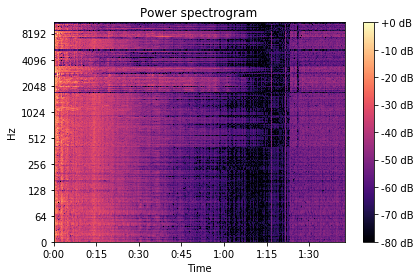

In [74]:
print(reverb_resamp.shape)
librosa.display.specshow(librosa.amplitude_to_db(pred,ref=np.max),y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()